In [1]:
#!pip install yfinance
#!pip install pandas-ta

In [2]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [3]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [4]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="60d", interval="15m")
#df_analisys = yf.download('^GSPC', interval="5m", start="2022-02-16", end="2022-03-03")

df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(1561, 7)


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2021-12-08 09:30:00-05:00,4690.859863,4694.379883,4680.959961,4690.169922,4690.169922,88952780
1,2021-12-08 09:45:00-05:00,4690.129883,4698.629883,4685.560059,4686.959961,4686.959961,115615460
2,2021-12-08 10:00:00-05:00,4686.890137,4692.000000,4684.379883,4687.470215,4687.470215,96584746
3,2021-12-08 10:15:00-05:00,4687.180176,4693.660156,4680.810059,4680.810059,4680.810059,86482361
4,2021-12-08 10:30:00-05:00,4680.540039,4687.430176,4680.120117,4681.890137,4681.890137,79589863
...,...,...,...,...,...,...,...
1556,2022-03-04 15:00:00-05:00,4299.029785,4314.330078,4298.819824,4303.890137,4303.890137,87080000
1557,2022-03-04 15:15:00-05:00,4303.790039,4318.979980,4302.759766,4312.620117,4312.620117,104534000
1558,2022-03-04 15:30:00-05:00,4312.649902,4315.430176,4302.370117,4310.640137,4310.640137,132323000
1559,2022-03-04 15:45:00-05:00,4310.649902,4331.660156,4306.020020,4329.359863,4329.359863,325730000


In [5]:
df_analisys.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_5m_raw' + '.pkl')
print(df_analisys.shape)

(1561, 7)


In [7]:
#df_analisys[ (df_analisys['Datetime']>=dt.datetime(2022,3,3,15,30))]

# Candles computations

In [8]:
#Fixes the trading date
df_analisys['Datetime'] = df_analisys['Datetime'].dt.tz_localize(None)
df_analisys['Datetime']

0      2021-12-08 09:30:00
1      2021-12-08 09:45:00
2      2021-12-08 10:00:00
3      2021-12-08 10:15:00
4      2021-12-08 10:30:00
               ...        
1556   2022-03-04 15:00:00
1557   2022-03-04 15:15:00
1558   2022-03-04 15:30:00
1559   2022-03-04 15:45:00
1560   2022-03-04 16:00:00
Name: Datetime, Length: 1561, dtype: datetime64[ns]

In [9]:
df_analisys['date'] = df_analisys['Datetime'].apply(lambda x: x.date())
df_analisys['date']

0       2021-12-08
1       2021-12-08
2       2021-12-08
3       2021-12-08
4       2021-12-08
           ...    
1556    2022-03-04
1557    2022-03-04
1558    2022-03-04
1559    2022-03-04
1560    2022-03-04
Name: date, Length: 1561, dtype: object

In [10]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2021-12-08 09:30:00,4690.859863,4694.379883,4680.959961,4690.169922,4690.169922,88952780,2021-12-08,-0.689941,0.689941,3.520020,9.209961
1,2021-12-08 09:45:00,4690.129883,4698.629883,4685.560059,4686.959961,4686.959961,115615460,2021-12-08,-3.169922,3.169922,8.500000,1.399902
2,2021-12-08 10:00:00,4686.890137,4692.000000,4684.379883,4687.470215,4687.470215,96584746,2021-12-08,0.580078,0.580078,4.529785,2.510254
3,2021-12-08 10:15:00,4687.180176,4693.660156,4680.810059,4680.810059,4680.810059,86482361,2021-12-08,-6.370117,6.370117,6.479980,0.000000
4,2021-12-08 10:30:00,4680.540039,4687.430176,4680.120117,4681.890137,4681.890137,79589863,2021-12-08,1.350098,1.350098,5.540039,0.419922
5,2021-12-08 10:45:00,4681.979980,4682.990234,4675.959961,4676.270020,4676.270020,75241949,2021-12-08,-5.709961,5.709961,1.010254,0.310059
6,2021-12-08 11:00:00,4676.259766,4682.819824,4674.520020,4682.479980,4682.479980,64434063,2021-12-08,6.220215,6.220215,0.339844,1.739746
7,2021-12-08 11:15:00,4682.500000,4685.180176,4679.319824,4685.169922,4685.169922,64371086,2021-12-08,2.669922,2.669922,0.010254,3.180176
8,2021-12-08 11:30:00,4685.229980,4686.970215,4680.910156,4682.750000,4682.750000,57835629,2021-12-08,-2.479980,2.479980,1.740234,1.839844
9,2021-12-08 11:45:00,4682.720215,4688.459961,4682.720215,4686.790039,4686.790039,49989061,2021-12-08,4.069824,4.069824,1.669922,0.000000


In [11]:
#Computes candles color
df_analisys['body_disposal']=None
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1    0.0            761
0    1.0            798
2    NaN              2


# Target signal

In [12]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    profit_threshold = 30
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        s_threshold = ((df_analisys['Close'][i] - df_analisys['Close'].iloc[i+1:]).abs() > profit_threshold)
        idxs = s_threshold[s_threshold].index
        
        try:
            target_idx = [min(idxs)]
        except:
            target_idx = []
        
        df_data = df_analisys.iloc[target_idx]

        Datetime = df_analisys['Datetime'][i]

        keepcols = ['Datetime','Close']
        df_data = df_data[keepcols]

        dic_rencols = {
            'Datetime':'target_date',
            'Close': 'target_close',
        }

        df_data = df_data.rename(columns=dic_rencols)
        df_data['Datetime'] = Datetime

        if i == 0:
            df_target =df_data.copy()
        else:
            df_target =df_target.append(df_data).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,target_date,target_close,Datetime
0,2021-12-14 09:30:00,4657.140137,2021-12-08 09:30:00
1,2021-12-14 09:45:00,4649.310059,2021-12-08 09:45:00
2,2021-12-14 09:30:00,4657.140137,2021-12-08 10:00:00
3,2021-12-10 15:45:00,4711.649902,2021-12-08 10:15:00
4,2021-12-14 09:45:00,4649.310059,2021-12-08 10:30:00
...,...,...,...
1539,2022-03-04 13:00:00,4333.049805,2022-03-04 11:15:00
1540,2022-03-04 13:00:00,4333.049805,2022-03-04 11:30:00
1541,2022-03-04 13:00:00,4333.049805,2022-03-04 11:45:00
1542,2022-03-04 14:45:00,4299.009766,2022-03-04 13:00:00


In [13]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['Datetime'],
                         how = 'left').copy()

#Computes the target difference in closure prices
df_analisys_01['target_difference'] =  round( df_analisys_01['target_close'] - df_analisys_01['Close'] )

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_difference'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(1561, 13)
(1561, 16)
     index  target_difference
86  -115.0                  1
107 -109.0                  1
72  -108.0                  2
92  -104.0                  1
87   -99.0                  1
..     ...                ...
53    73.0                  5
71    74.0                  2
95    79.0                  1
99    83.0                  1
28     NaN                 17

[109 rows x 2 columns]


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference
0,2021-12-08 09:30:00,4690.859863,4694.379883,4680.959961,4690.169922,4690.169922,88952780,2021-12-08,-0.689941,0.689941,3.520020,9.209961,0,2021-12-14 09:30:00,4657.140137,-33.0
1,2021-12-08 09:45:00,4690.129883,4698.629883,4685.560059,4686.959961,4686.959961,115615460,2021-12-08,-3.169922,3.169922,8.500000,1.399902,0,2021-12-14 09:45:00,4649.310059,-38.0
2,2021-12-08 10:00:00,4686.890137,4692.000000,4684.379883,4687.470215,4687.470215,96584746,2021-12-08,0.580078,0.580078,4.529785,2.510254,1,2021-12-14 09:30:00,4657.140137,-30.0
3,2021-12-08 10:15:00,4687.180176,4693.660156,4680.810059,4680.810059,4680.810059,86482361,2021-12-08,-6.370117,6.370117,6.479980,0.000000,0,2021-12-10 15:45:00,4711.649902,31.0
4,2021-12-08 10:30:00,4680.540039,4687.430176,4680.120117,4681.890137,4681.890137,79589863,2021-12-08,1.350098,1.350098,5.540039,0.419922,1,2021-12-14 09:45:00,4649.310059,-33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,2022-03-04 15:00:00,4299.029785,4314.330078,4298.819824,4303.890137,4303.890137,87080000,2022-03-04,4.860352,4.860352,10.439941,0.209961,1,NaT,NaN,NaN
1557,2022-03-04 15:15:00,4303.790039,4318.979980,4302.759766,4312.620117,4312.620117,104534000,2022-03-04,8.830078,8.830078,6.359863,1.030273,1,NaT,NaN,NaN
1558,2022-03-04 15:30:00,4312.649902,4315.430176,4302.370117,4310.640137,4310.640137,132323000,2022-03-04,-2.009766,2.009766,2.780273,8.270020,0,NaT,NaN,NaN
1559,2022-03-04 15:45:00,4310.649902,4331.660156,4306.020020,4329.359863,4329.359863,325730000,2022-03-04,18.709961,18.709961,2.300293,4.629883,1,NaT,NaN,NaN


In [14]:
df_varbins = df_analisys_01[['target_difference']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_difference'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                   index  target_bins
20                00-nan           17
8   01-(-115.001, -54.0]           82
6      02-(-54.0, -45.0]           84
12     03-(-45.0, -41.0]           70
3      04-(-41.0, -38.0]           95
2      05-(-38.0, -36.0]          102
16     06-(-36.0, -35.0]           63
9      07-(-35.0, -34.0]           80
5      08-(-34.0, -33.0]           85
7      09-(-33.0, -32.0]           83
1      10-(-32.0, -31.0]          103
14     11-(-31.0, -30.0]           64
19      12-(-30.0, 30.0]           35
13       13-(30.0, 31.0]           68
0        14-(31.0, 33.0]          121
17       15-(33.0, 34.0]           55
18       16-(34.0, 35.4]           45
4        17-(35.4, 38.0]           93
15       18-(38.0, 41.0]           64
10       19-(41.0, 49.0]           80
11       20-(49.0, 83.0]           72


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['Datetime']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,target_date,target_close,target_difference,target_date_diff
0,2021-12-08 09:30:00,4690.859863,4694.379883,4680.959961,4690.169922,4690.169922,88952780,2021-12-08,-0.689941,0.689941,3.520020,9.209961,0,2021-12-14 09:30:00,4657.140137,-33.0,8640.0
1,2021-12-08 09:45:00,4690.129883,4698.629883,4685.560059,4686.959961,4686.959961,115615460,2021-12-08,-3.169922,3.169922,8.500000,1.399902,0,2021-12-14 09:45:00,4649.310059,-38.0,8640.0
2,2021-12-08 10:00:00,4686.890137,4692.000000,4684.379883,4687.470215,4687.470215,96584746,2021-12-08,0.580078,0.580078,4.529785,2.510254,1,2021-12-14 09:30:00,4657.140137,-30.0,8610.0
3,2021-12-08 10:15:00,4687.180176,4693.660156,4680.810059,4680.810059,4680.810059,86482361,2021-12-08,-6.370117,6.370117,6.479980,0.000000,0,2021-12-10 15:45:00,4711.649902,31.0,3210.0
4,2021-12-08 10:30:00,4680.540039,4687.430176,4680.120117,4681.890137,4681.890137,79589863,2021-12-08,1.350098,1.350098,5.540039,0.419922,1,2021-12-14 09:45:00,4649.310059,-33.0,8595.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,2022-03-04 15:00:00,4299.029785,4314.330078,4298.819824,4303.890137,4303.890137,87080000,2022-03-04,4.860352,4.860352,10.439941,0.209961,1,NaT,NaN,NaN,NaN
1557,2022-03-04 15:15:00,4303.790039,4318.979980,4302.759766,4312.620117,4312.620117,104534000,2022-03-04,8.830078,8.830078,6.359863,1.030273,1,NaT,NaN,NaN,NaN
1558,2022-03-04 15:30:00,4312.649902,4315.430176,4302.370117,4310.640137,4310.640137,132323000,2022-03-04,-2.009766,2.009766,2.780273,8.270020,0,NaT,NaN,NaN,NaN
1559,2022-03-04 15:45:00,4310.649902,4331.660156,4306.020020,4329.359863,4329.359863,325730000,2022-03-04,18.709961,18.709961,2.300293,4.629883,1,NaT,NaN,NaN,NaN


In [16]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

print(df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                    index  target_date_bins
20                 00-nan                17
0       01-(14.999, 45.0]               119
18        02-(45.0, 60.0]                59
17        03-(60.0, 75.0]                60
1        04-(75.0, 105.0]               102
3       05-(105.0, 135.0]                82
19      06-(135.0, 165.0]                58
13      07-(165.0, 210.0]                75
15      08-(210.0, 270.0]                69
6      09-(270.0, 1095.0]                79
4     10-(1095.0, 1155.0]                81
8     11-(1155.0, 1215.0]                78
16    12-(1215.0, 1275.0]                68
5     13-(1275.0, 1350.0]                80
2     14-(1350.0, 1440.0]                82
14    15-(1440.0, 1605.0]                69
12    16-(1605.0, 3945.0]                76
11    17-(3945.0, 4215.0]                76
9     18-(4215.0, 5595.0]                77
10   19-(5595.0, 8337.75]                76
7   20-(8337.75, 12855.0]                78


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

1155.0

In [18]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0    45.0
dtype: float64


In [19]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_difference'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_difference'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_difference'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_difference'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'


df_analisys_01.loc[abs(df_analisys_01['target_difference']) < profit_threshold, 'target_order'] = 'NULL'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'] == 'BUY', 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
2    BUY           359
3   BUY2           274
4   NULL            17
1   SELL           425
0  SELL2           486
   index  target_order_bin
0      0              1202
1      1               359


# MACD and EMA indicators

In [20]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys_01.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
1556,-9.829668,1.104178,-10.933846
1557,-9.002433,1.545130,-10.547564
1558,-8.409671,1.710314,-10.119985
1559,-6.356107,3.011102,-9.367210


In [21]:
ewm50 = df_analisys_01['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys_01['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys_01['diff_ewm50'] = df_analisys_01['Close'] - ewm50
df_analisys_01['diff_ewm200'] = df_analisys_01['Close'] - ewm200

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2021-12-08 09:30:00,4690.859863,4694.379883,4680.959961,4690.169922,4690.169922,88952780,2021-12-08,-0.689941,0.689941,...,4657.140137,-33.0,8640.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
1,2021-12-08 09:45:00,4690.129883,4698.629883,4685.560059,4686.959961,4686.959961,115615460,2021-12-08,-3.169922,3.169922,...,4649.310059,-38.0,8640.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
2,2021-12-08 10:00:00,4686.890137,4692.000000,4684.379883,4687.470215,4687.470215,96584746,2021-12-08,0.580078,0.580078,...,4657.140137,-30.0,8610.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
3,2021-12-08 10:15:00,4687.180176,4693.660156,4680.810059,4680.810059,4680.810059,86482361,2021-12-08,-6.370117,6.370117,...,4711.649902,31.0,3210.0,BUY2,0,NaN,NaN,NaN,NaN,NaN
4,2021-12-08 10:30:00,4680.540039,4687.430176,4680.120117,4681.890137,4681.890137,79589863,2021-12-08,1.350098,1.350098,...,4649.310059,-33.0,8595.0,SELL2,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,2022-03-04 15:00:00,4299.029785,4314.330078,4298.819824,4303.890137,4303.890137,87080000,2022-03-04,4.860352,4.860352,...,NaN,NaN,NaN,NULL,0,-9.829668,1.104178,-10.933846,-30.168912,-40.728512
1557,2022-03-04 15:15:00,4303.790039,4318.979980,4302.759766,4312.620117,4312.620117,104534000,2022-03-04,8.830078,8.830078,...,NaN,NaN,NaN,NULL,0,-9.002433,1.545130,-10.547564,-20.598189,-31.680138
1558,2022-03-04 15:30:00,4312.649902,4315.430176,4302.370117,4310.640137,4310.640137,132323000,2022-03-04,-2.009766,2.009766,...,NaN,NaN,NaN,NULL,0,-8.409671,1.710314,-10.119985,-21.692751,-33.325192
1559,2022-03-04 15:45:00,4310.649902,4331.660156,4306.020020,4329.359863,4329.359863,325730000,2022-03-04,18.709961,18.709961,...,NaN,NaN,NaN,NULL,0,-6.356107,3.011102,-9.367210,-2.856435,-14.460137


In [22]:
#Keeps only the data where MACD is available

df_analisys_02 = df_analisys_01[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys_01.shape)
print(df_analisys_02.shape)

df_analisys_02

(1561, 24)
(1362, 24)


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,target_close,target_difference,target_date_diff,target_order,target_order_bin,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
199,2021-12-17 13:45:00,4644.589844,4656.379883,4644.589844,4655.870117,4655.870117,51160000,2021-12-17,11.280273,11.280273,...,4620.259766,-36.0,120.0,SELL,0,-5.472012,2.877770,-8.349782,1.281053,-9.968319
200,2021-12-17 14:00:00,4655.839844,4656.250000,4648.680176,4650.390137,4650.390137,54745000,2021-12-17,-5.449707,5.449707,...,4620.259766,-30.0,105.0,SELL,0,-4.518791,3.064793,-7.583584,-4.034264,-15.294585
201,2021-12-17 14:15:00,4650.299805,4654.390137,4640.830078,4642.649902,4642.649902,59885000,2021-12-17,-7.649902,7.649902,...,4561.040039,-82.0,4035.0,SELL2,0,-4.337923,2.596528,-6.934452,-11.312753,-22.805618
202,2021-12-17 14:30:00,4642.640137,4646.029785,4639.500000,4645.759766,4645.759766,56280000,2021-12-17,3.119629,3.119629,...,4561.040039,-85.0,4020.0,SELL2,0,-3.898703,2.428599,-6.327302,-7.881208,-19.499777
203,2021-12-17 14:45:00,4646.100098,4651.870117,4638.310059,4642.950195,4642.950195,57865000,2021-12-17,-3.149902,3.149902,...,4561.040039,-82.0,4005.0,SELL2,0,-3.734280,2.074418,-5.808697,-10.271532,-22.087363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,2022-03-04 15:00:00,4299.029785,4314.330078,4298.819824,4303.890137,4303.890137,87080000,2022-03-04,4.860352,4.860352,...,NaN,NaN,NaN,NULL,0,-9.829668,1.104178,-10.933846,-30.168912,-40.728512
1557,2022-03-04 15:15:00,4303.790039,4318.979980,4302.759766,4312.620117,4312.620117,104534000,2022-03-04,8.830078,8.830078,...,NaN,NaN,NaN,NULL,0,-9.002433,1.545130,-10.547564,-20.598189,-31.680138
1558,2022-03-04 15:30:00,4312.649902,4315.430176,4302.370117,4310.640137,4310.640137,132323000,2022-03-04,-2.009766,2.009766,...,NaN,NaN,NaN,NULL,0,-8.409671,1.710314,-10.119985,-21.692751,-33.325192
1559,2022-03-04 15:45:00,4310.649902,4331.660156,4306.020020,4329.359863,4329.359863,325730000,2022-03-04,18.709961,18.709961,...,NaN,NaN,NaN,NULL,0,-6.356107,3.011102,-9.367210,-2.856435,-14.460137


In [23]:
df_varbins = df_analisys_02[['diff_ewm50']]
df_varbins['diff_bins'] = pd.qcut(df_varbins['diff_ewm50'], 20, duplicates='drop')
df_varbins['diff_bins'] = df_varbins['diff_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['diff_bins'].astype(str)



print(df_varbins['diff_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

df_varbins = abs(df_analisys_02[['diff_ewm50']])
print('Absolute mean difference with: ' ,df_varbins.mean())

df_varbins = abs(df_analisys_02[['diff_ewm200']])
print('Absolute mean difference with: ' ,df_varbins.mean())

                                index  diff_bins
1   01-(-175.03300000000002, -75.146]         69
15              02-(-75.146, -58.155]         68
14              03-(-58.155, -48.618]         68
13              04-(-48.618, -40.122]         68
12              05-(-40.122, -33.709]         68
16              06-(-33.709, -26.792]         68
19              07-(-26.792, -21.606]         68
17                08-(-21.606, -16.0]         68
18                 09-(-16.0, -9.635]         68
11                10-(-9.635, -3.921]         68
8                  11-(-3.921, 0.973]         68
10                  12-(0.973, 6.965]         68
9                  13-(6.965, 11.798]         68
2                 14-(11.798, 16.729]         68
7                 15-(16.729, 25.821]         68
6                 16-(25.821, 33.527]         68
5                 17-(33.527, 40.076]         68
4                 18-(40.076, 46.936]         68
3                 19-(46.936, 58.243]         68
0                 20

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Data preparation

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Close price info

In [606]:
# Prepares previos close info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 50

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Close']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Close']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss1_close_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag + i):,][['Close']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Close']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss2 = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss2_close_' + str(x) for x in range(len(X_ss2),0,-1) ]
    df_ssdata2 = pd.DataFrame(X_ss2.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 200

    if i==0:
        X3 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['Close']]
    else:
        X3 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['Close']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss3 = sscaler.fit_transform(X3)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss3_close_' + str(x) for x in range(len(X_ss3),0,-1) ]
    df_ssdata3 = pd.DataFrame(X_ss3.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss1[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_close_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_close_info = pd.concat([df_ssdata1,df_ssdata2,df_ssdata3, df_linregcoefs],axis=1,sort=False)
    df_close_info['Datetime'] = Datetime
    
    if i == 0:
        df_close_info_01 = df_close_info.copy()
    else:
        df_close_info_01 = df_close_info_01.append(df_close_info,sort=False).copy()
        
df_close_info_01 = df_close_info_01.reset_index(drop=True)
df_close_info_01

,ss1_close_50,ss1_close_49,ss1_close_48,ss1_close_47,ss1_close_46,ss1_close_45,ss1_close_44,ss1_close_43,ss1_close_42,ss1_close_41,...,ss3_close_5,ss3_close_4,ss3_close_3,ss3_close_2,ss3_close_1,slope_close_0,slope_close_1,slope_close_2,slope_close_3,Datetime
0,-1.122689,-1.019692,-0.902399,-0.595315,-0.588656,-1.042554,-0.764106,-0.443705,-0.349275,-0.373115,...,1.457240,1.579149,1.526643,1.196556,-0.546000,-3.218447,-1.363090,-0.575459,-0.189710,2022-03-04 16:00:00
1,-2.704887,-1.981731,-1.812656,-1.620115,-1.116023,-1.105093,-1.850186,-1.393102,-0.867150,-0.712138,...,1.476379,1.454864,1.576859,1.524316,1.193995,-0.975240,-0.252336,-0.033949,0.051471,2022-03-02 15:55:00
2,-2.600308,-2.487728,-1.812319,-1.654407,-1.474578,-1.003769,-0.993561,-1.689459,-1.262554,-0.771327,...,1.564838,1.485612,1.464025,1.586425,1.533708,0.165229,0.018283,0.139491,0.108433,2022-03-02 15:50:00
3,-2.619356,-2.360942,-2.255668,-1.624086,-1.476422,-1.308263,-0.868005,-0.858459,-1.509199,-1.109996,...,1.478838,1.579908,1.500230,1.478520,1.601618,0.223533,0.063572,0.180648,0.072512,2022-03-02 15:45:00
4,-1.266043,-2.562230,-2.304603,-2.199649,-1.569991,-1.422776,-1.255129,-0.816212,-0.806694,-1.455453,...,1.365317,1.492876,1.594533,1.514392,1.492556,-0.222853,0.120627,0.122880,0.018975,2022-03-02 15:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.343770,-0.633274,-1.318657,1.655209,-0.047047,0.635805,0.150685,NaN,NaN,2022-02-18 13:25:00
578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.297040,-0.577097,-1.190292,1.470350,1.023724,NaN,NaN,NaN,2022-02-18 13:20:00
579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.289769,-0.142519,-1.147250,-1.218510,NaN,NaN,NaN,2022-02-18 13:15:00
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,2022-02-18 13:10:00


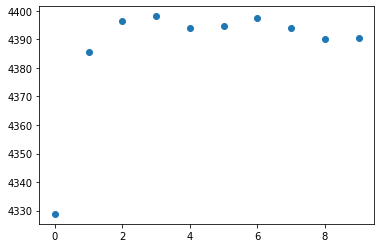

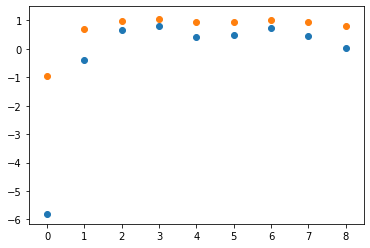

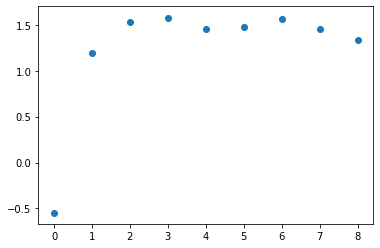

In [607]:
data = df_analisys_02.iloc[-10:,:]['Close'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_close_info_01.iloc[0,:][['ss1_close_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show

data = df_close_info_01.iloc[0,:][['ss2_close_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_close_info_01.iloc[0,:][['ss3_close_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

In [608]:
ls_ss1vars = ['ss1_close_' + str(x) for x in range(50,8,-1)]
ls_ss1vars

ls_ss1vars2 = ['ss1_close_' + str(x) for x in range(8,0,-1) ]
ls_ss1vars2

ls_ss2vars = ['ss2_close_' + str(x) for x in range(100,0,-1) ]
ls_ss2vars

ls_ss3vars = ['ss3_close_' + str(x) for x in range(200,0,-1) ]
ls_ss3vars

ls_slopevars = ['slope_close_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_close_0', 'slope_close_1', 'slope_close_2', 'slope_close_3']

In [609]:
#Assigns correct format to variable to apply transformations
df_close_info_01[ls_ss1vars] = df_close_info_01[ls_ss1vars].astype(float)
df_close_info_01[ls_ss1vars2] = df_close_info_01[ls_ss1vars2].astype(float)
df_close_info_01[ls_ss2vars] = df_close_info_01[ls_ss2vars].astype(float)
df_close_info_01[ls_ss3vars] = df_close_info_01[ls_ss3vars].astype(float)
df_close_info_01[ls_slopevars] = df_close_info_01[ls_slopevars].astype(float)

In [610]:
df_close_info_01 = df_close_info_01[df_close_info_01.notna().all(axis=1)]

df_close_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars + ls_ss2vars + ls_ss3vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 0 to 382
Columns: 354 entries, slope_close_0 to ss3_close_1
dtypes: float64(354)
memory usage: 1.0 MB


In [611]:
#Defines X vector to all process

X = df_close_info_01[ls_slopevars + ls_ss1vars2 + ls_ss1vars + ls_ss2vars + ls_ss3vars]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(383, 354)


In [612]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss1vars2),
                                     ("pca1", pca_pip, ls_ss1vars),
                                     ("pca2", pca_pip, ls_ss2vars),
                                     ("pca3", pca_pip, ls_ss3vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [613]:
Xtr.shape

(383, 21)

In [614]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_close_c1','ss1_close_c2','ss1_close_c3']
ls_ss2pcavars = ['ss2_close_c1','ss2_close_c2','ss2_close_c3']
ls_ss3pcavars = ['ss3_close_c1','ss3_close_c2','ss3_close_c3']

df_close_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss1vars2 + ls_ss1pcavars + ls_ss2pcavars + ls_ss3pcavars)
print(df_close_info_tr_01.shape)
df_close_info_tr_01

(383, 21)


,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,ss1_close_3,...,ss1_close_1,ss1_close_c1,ss1_close_c2,ss1_close_c3,ss2_close_c1,ss2_close_c2,ss2_close_c3,ss3_close_c1,ss3_close_c2,ss3_close_c3
0,-3.218447,-1.363090,-0.575459,-0.189710,0.431729,0.742585,0.497523,0.430751,0.809356,0.646292,...,-5.790601,-1.408349,2.416502,0.128889,8.783424,-3.856228,0.807072,9.503285,7.356216,-1.230260
1,-0.975240,-0.252336,-0.033949,0.051471,-0.070386,0.569913,1.080197,0.677917,0.568308,1.189805,...,-0.760675,-3.903906,3.648697,0.132692,9.101011,-3.424913,0.739592,9.445165,7.751295,-0.812117
2,0.165229,0.018283,0.139491,0.108433,0.012307,-0.027171,0.570853,1.047445,0.671726,0.569354,...,0.899813,-4.255138,3.344075,0.237143,9.164875,-3.245147,0.799240,9.257238,7.975028,-0.580368
3,0.223533,0.063572,0.180648,0.072512,-0.306118,0.082137,0.045221,0.604438,1.050103,0.698765,...,1.145831,-4.599166,3.005670,0.252349,9.208826,-3.111074,0.882789,9.059642,8.167984,-0.369349
4,-0.222853,0.120627,0.122880,0.018975,0.384605,-0.256035,0.131038,0.094234,0.651748,1.096056,...,0.650351,-4.767126,2.686114,0.615258,9.249634,-2.974929,0.969858,8.836373,8.371992,-0.188443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,-0.011774,-0.035421,0.053647,0.066477,-1.407629,-1.877554,-1.612013,-1.279365,-1.059362,-1.236020,...,-1.259567,5.557401,2.342152,1.234650,-8.743734,-3.440903,2.852578,-10.455821,-3.930679,-6.752977
379,-0.196954,0.036114,0.055254,0.005070,-1.646924,-1.459216,-1.929265,-1.663654,-1.330918,-1.110856,...,-1.504765,5.357239,2.138563,1.173381,-8.697142,-3.412140,2.918757,-10.405171,-3.877305,-6.655954
380,0.021759,0.184302,0.071939,-0.040717,-1.737078,-1.712111,-1.523707,-1.995499,-1.728903,-1.394933,...,-1.351416,5.190370,1.867276,1.090575,-8.653081,-3.378196,2.954581,-10.362227,-3.831237,-6.516413
381,0.276859,0.129722,0.094889,-0.088627,-2.197406,-1.790056,-1.765140,-1.577119,-2.047950,-1.781898,...,-1.228180,4.942376,1.474701,0.924782,-8.609630,-3.307749,2.992694,-10.309064,-3.788023,-6.373993


In [615]:
# Concat the Datetime to the transformed data

df_close_info_tr_01 = pd.concat([df_close_info_01['Datetime'],df_close_info_tr_01],axis=1)
df_close_info_tr_01

,Datetime,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,...,ss1_close_1,ss1_close_c1,ss1_close_c2,ss1_close_c3,ss2_close_c1,ss2_close_c2,ss2_close_c3,ss3_close_c1,ss3_close_c2,ss3_close_c3
0,2022-03-04 16:00:00,-3.218447,-1.363090,-0.575459,-0.189710,0.431729,0.742585,0.497523,0.430751,0.809356,...,-5.790601,-1.408349,2.416502,0.128889,8.783424,-3.856228,0.807072,9.503285,7.356216,-1.230260
1,2022-03-02 15:55:00,-0.975240,-0.252336,-0.033949,0.051471,-0.070386,0.569913,1.080197,0.677917,0.568308,...,-0.760675,-3.903906,3.648697,0.132692,9.101011,-3.424913,0.739592,9.445165,7.751295,-0.812117
2,2022-03-02 15:50:00,0.165229,0.018283,0.139491,0.108433,0.012307,-0.027171,0.570853,1.047445,0.671726,...,0.899813,-4.255138,3.344075,0.237143,9.164875,-3.245147,0.799240,9.257238,7.975028,-0.580368
3,2022-03-02 15:45:00,0.223533,0.063572,0.180648,0.072512,-0.306118,0.082137,0.045221,0.604438,1.050103,...,1.145831,-4.599166,3.005670,0.252349,9.208826,-3.111074,0.882789,9.059642,8.167984,-0.369349
4,2022-03-02 15:40:00,-0.222853,0.120627,0.122880,0.018975,0.384605,-0.256035,0.131038,0.094234,0.651748,...,0.650351,-4.767126,2.686114,0.615258,9.249634,-2.974929,0.969858,8.836373,8.371992,-0.188443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,2022-02-24 10:30:00,-0.011774,-0.035421,0.053647,0.066477,-1.407629,-1.877554,-1.612013,-1.279365,-1.059362,...,-1.259567,5.557401,2.342152,1.234650,-8.743734,-3.440903,2.852578,-10.455821,-3.930679,-6.752977
379,2022-02-24 10:25:00,-0.196954,0.036114,0.055254,0.005070,-1.646924,-1.459216,-1.929265,-1.663654,-1.330918,...,-1.504765,5.357239,2.138563,1.173381,-8.697142,-3.412140,2.918757,-10.405171,-3.877305,-6.655954
380,2022-02-24 10:20:00,0.021759,0.184302,0.071939,-0.040717,-1.737078,-1.712111,-1.523707,-1.995499,-1.728903,...,-1.351416,5.190370,1.867276,1.090575,-8.653081,-3.378196,2.954581,-10.362227,-3.831237,-6.516413
381,2022-02-24 10:15:00,0.276859,0.129722,0.094889,-0.088627,-2.197406,-1.790056,-1.765140,-1.577119,-2.047950,...,-1.228180,4.942376,1.474701,0.924782,-8.609630,-3.307749,2.992694,-10.309064,-3.788023,-6.373993


In [616]:
pd.concat([df_close_info_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:],
           df_close_info_01[['Datetime'] +ls_ss1vars2].iloc[0:1,:]],axis=0)

,Datetime,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,ss1_close_3,ss1_close_2,ss1_close_1
0,2022-03-04 16:00:00,0.431729,0.742585,0.497523,0.430751,0.809356,0.646292,-0.378843,-5.790601
0,2022-03-04 16:00:00,0.431729,0.742585,0.497523,0.430751,0.809356,0.646292,-0.378843,-5.790601


## MACD info

### Histogram

In [617]:
for c in df_analisys_02.columns.tolist():
    print(c)

Datetime
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
target_date
target_close
target_difference
target_date_diff
target_order
target_order_bin
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [618]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 13

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACDh_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macdh_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 30

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['MACDh_12_26_9']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['MACDh_12_26_9']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss160_macdh_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    # Keep anly a few of this standarization
    
    try:
        ls_keepcols = ['ss160_macdh_' + str(x) for x in range(30,0,-1) ]
        df_ssdata2 = df_ssdata2[ls_keepcols]
    except:
        pass
    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macdh_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macdh_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_macdh_info['Datetime'] = Datetime
    
    if i == 0:
        df_macdh_info_01 = df_macdh_info.copy()
    else:
        df_macdh_info_01 = df_macdh_info_01.append(df_macdh_info,sort=False).copy()
        
df_macdh_info_01 = df_macdh_info_01.reset_index(drop=True)
df_macdh_info_01

,ss80_macdh_13,ss80_macdh_12,ss80_macdh_11,ss80_macdh_10,ss80_macdh_9,ss80_macdh_8,ss80_macdh_7,ss80_macdh_6,ss80_macdh_5,ss80_macdh_4,...,ss160_macdh_5,ss160_macdh_4,ss160_macdh_3,ss160_macdh_2,ss160_macdh_1,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,Datetime
0,-0.329334,-0.221955,-0.376813,-0.272308,-0.178195,0.145610,0.552718,0.672494,0.708784,0.946931,...,1.050048,1.385076,1.443118,0.628278,-4.230952,-2.016642,-0.804571,-0.260338,-0.009458,2022-03-04 16:00:00
1,-1.621501,-0.945687,-0.746651,-1.033693,-0.839983,-0.665537,-0.065337,0.689273,0.911288,0.978555,...,1.331639,1.413104,1.947706,2.040322,0.740089,-0.498571,-0.045900,0.210559,0.241964,2022-03-02 15:55:00
2,-1.025136,-1.441202,-0.790794,-0.599241,-0.875492,-0.689065,-0.521177,0.056459,0.782700,0.996368,...,1.081024,1.351662,1.433661,1.971763,2.064986,0.249215,0.204324,0.345278,0.254945,2022-03-02 15:50:00
3,-0.322679,-0.971267,-1.435198,-0.709966,-0.496376,-0.804408,-0.596534,-0.409332,0.234756,1.044545,...,0.222589,1.208457,1.498511,1.586393,2.163098,0.272945,0.349829,0.405659,0.233694,2022-03-02 15:45:00
4,-0.276611,-0.176812,-0.938038,-1.482539,-0.631358,-0.380674,-0.742201,-0.498226,-0.278513,0.477433,...,-0.561117,0.268669,1.311930,1.618869,1.711867,0.182174,0.537148,0.404676,0.207505,2022-03-02 15:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.668628,-0.740461,...,-0.668628,-0.740461,-1.013477,1.064470,1.358095,1.185786,0.585838,NaN,NaN,2022-02-18 13:25:00
578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.400983,...,NaN,-0.400983,-0.488506,-0.821150,1.710639,1.099573,NaN,NaN,NaN,2022-02-18 13:20:00
579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.934965,0.451419,-1.386384,-1.160675,NaN,NaN,NaN,2022-02-18 13:15:00
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,2022-02-18 13:10:00


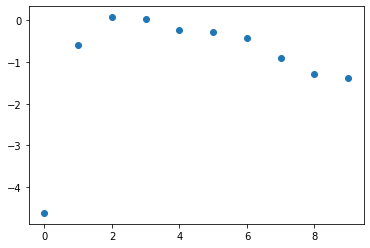

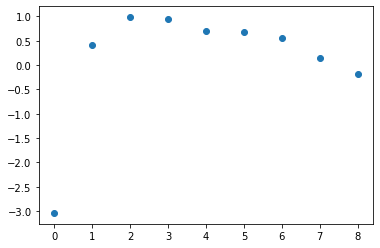

In [619]:
data = df_analisys_02.iloc[-10:,:]['MACDh_12_26_9'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_macdh_info_01.iloc[0,:][['ss80_macdh_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

In [620]:
# Create variable names lists to naming columns

ls_ss160vars = ['ss160_macdh_' + str(x) for x in range(30,0,-1)]
ls_ss160vars

ls_ss80vars = ['ss80_macdh_' + str(x) for x in range(12,4,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macdh_' + str(x) for x in range(4,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macdh_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macdh_0', 'slope_macdh_1', 'slope_macdh_2', 'slope_macdh_3']

In [621]:
#Assigns correct format to variable to apply transformations
df_macdh_info_01[ls_ss80vars2] = df_macdh_info_01[ls_ss80vars2].astype(float)
df_macdh_info_01[ls_ss80vars] = df_macdh_info_01[ls_ss80vars].astype(float)
df_macdh_info_01[ls_ss160vars] = df_macdh_info_01[ls_ss160vars].astype(float)
df_macdh_info_01[ls_slopevars] = df_macdh_info_01[ls_slopevars].astype(float)

In [622]:
df_macdh_info_01 = df_macdh_info_01[df_macdh_info_01.notna().all(axis=1)]

df_macdh_info_01[ls_slopevars + ls_ss80vars2 + ls_ss80vars + ls_ss160vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 553 entries, 0 to 552
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   slope_macdh_0   553 non-null    float64
 1   slope_macdh_1   553 non-null    float64
 2   slope_macdh_2   553 non-null    float64
 3   slope_macdh_3   553 non-null    float64
 4   ss80_macdh_4    553 non-null    float64
 5   ss80_macdh_3    553 non-null    float64
 6   ss80_macdh_2    553 non-null    float64
 7   ss80_macdh_1    553 non-null    float64
 8   ss80_macdh_12   553 non-null    float64
 9   ss80_macdh_11   553 non-null    float64
 10  ss80_macdh_10   553 non-null    float64
 11  ss80_macdh_9    553 non-null    float64
 12  ss80_macdh_8    553 non-null    float64
 13  ss80_macdh_7    553 non-null    float64
 14  ss80_macdh_6    553 non-null    float64
 15  ss80_macdh_5    553 non-null    float64
 16  ss160_macdh_30  553 non-null    float64
 17  ss160_macdh_29  553 non-null    flo

In [623]:
#Defines X vector to all process

X = df_macdh_info_01[ls_ss80vars + ls_ss160vars + ls_slopevars + ls_ss80vars2]
print(X.shape)

#y = df_analysis_01[Target_desc]
#y = df_analysis_02[Target_desc + '_coded']
#print(y.shape)

(553, 46)


In [624]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                     ("pca2", pca_pip, ls_ss160vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [625]:
Xtr.shape

(553, 14)

In [626]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macdh_c1','ss80_macdh_c2','ss80_macdh_c3']
ls_ss160pcavars = ['ss160_macdh_c1','ss160_macdh_c2','ss160_macdh_c3']

df_macdh_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars + ls_ss160pcavars)
print(df_macdh_info_tr_01.shape)
df_macdh_info_tr_01

(553, 14)


,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,-2.016642,-0.804571,-0.260338,-0.009458,0.946931,0.988188,0.408978,-3.045095,1.028802,0.448108,0.608846,0.265543,-1.879549,-0.630633
1,-0.498571,-0.045900,0.210559,0.241964,0.978555,1.419980,1.496455,0.422839,2.071012,-0.733312,0.365301,0.703376,-4.529454,1.721743
2,0.249215,0.204324,0.345278,0.254945,0.996368,1.061106,1.485937,1.559536,1.901068,-0.954204,-0.457789,-0.007996,-4.257202,2.253926
3,0.272945,0.349829,0.405659,0.233694,1.044545,1.282795,1.354980,1.828684,1.579742,-1.179204,-0.972069,-1.002257,-3.838627,2.265299
4,0.182174,0.537148,0.404676,0.207505,0.477433,1.427856,1.707481,1.792203,0.978646,-1.482964,-0.620040,-2.097011,-3.275114,1.891149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,0.128603,0.178943,-0.093149,-0.239913,-1.374242,-0.962890,-0.622563,-0.705684,-2.679927,0.078420,-0.036393,-3.223928,3.923464,-0.764884
549,0.364347,0.035008,-0.205132,-0.247115,-1.335055,-1.480159,-1.081386,-0.751466,-2.339610,0.693398,0.015534,-2.556837,4.299321,-1.115564
550,0.120414,-0.180755,-0.309757,-0.255598,-0.927078,-1.435359,-1.573118,-1.194531,-1.799893,1.072220,0.030297,-1.730410,4.555162,-1.334492
551,-0.314373,-0.336630,-0.369618,-0.257558,-0.811645,-1.116561,-1.611236,-1.745307,-1.418322,1.038785,0.363503,-0.817282,4.665300,-1.431737


In [627]:
# Concat the Datetime to the transformed data

df_macdh_info_tr_01 = pd.concat([df_macdh_info_01['Datetime'],df_macdh_info_tr_01],axis=1)
df_macdh_info_tr_01

,Datetime,slope_macdh_0,slope_macdh_1,slope_macdh_2,slope_macdh_3,ss80_macdh_4,ss80_macdh_3,ss80_macdh_2,ss80_macdh_1,ss80_macdh_c1,ss80_macdh_c2,ss80_macdh_c3,ss160_macdh_c1,ss160_macdh_c2,ss160_macdh_c3
0,2022-03-04 16:00:00,-2.016642,-0.804571,-0.260338,-0.009458,0.946931,0.988188,0.408978,-3.045095,1.028802,0.448108,0.608846,0.265543,-1.879549,-0.630633
1,2022-03-02 15:55:00,-0.498571,-0.045900,0.210559,0.241964,0.978555,1.419980,1.496455,0.422839,2.071012,-0.733312,0.365301,0.703376,-4.529454,1.721743
2,2022-03-02 15:50:00,0.249215,0.204324,0.345278,0.254945,0.996368,1.061106,1.485937,1.559536,1.901068,-0.954204,-0.457789,-0.007996,-4.257202,2.253926
3,2022-03-02 15:45:00,0.272945,0.349829,0.405659,0.233694,1.044545,1.282795,1.354980,1.828684,1.579742,-1.179204,-0.972069,-1.002257,-3.838627,2.265299
4,2022-03-02 15:40:00,0.182174,0.537148,0.404676,0.207505,0.477433,1.427856,1.707481,1.792203,0.978646,-1.482964,-0.620040,-2.097011,-3.275114,1.891149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2022-02-18 15:50:00,0.128603,0.178943,-0.093149,-0.239913,-1.374242,-0.962890,-0.622563,-0.705684,-2.679927,0.078420,-0.036393,-3.223928,3.923464,-0.764884
549,2022-02-18 15:45:00,0.364347,0.035008,-0.205132,-0.247115,-1.335055,-1.480159,-1.081386,-0.751466,-2.339610,0.693398,0.015534,-2.556837,4.299321,-1.115564
550,2022-02-18 15:40:00,0.120414,-0.180755,-0.309757,-0.255598,-0.927078,-1.435359,-1.573118,-1.194531,-1.799893,1.072220,0.030297,-1.730410,4.555162,-1.334492
551,2022-02-18 15:35:00,-0.314373,-0.336630,-0.369618,-0.257558,-0.811645,-1.116561,-1.611236,-1.745307,-1.418322,1.038785,0.363503,-0.817282,4.665300,-1.431737


### MACD model info

In [628]:
# Prepares previos MACD model info as input variables

for i in range(0,len(df_analisys_02)):
    #i=2
    
    ###############################################################################################
    nro_close_lag = 80

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['MACD_12_26_9']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_macd_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    
    try:
        ls_keepcols = ['ss80_macd_' + str(x) for x in range(80,0,-1) ]
        df_ssdata = df_ssdata[ls_keepcols]
    except:
        pass
    ###############################################################################################



    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_macd_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_macd_info = pd.concat([df_ssdata,df_linregcoefs],axis=1,sort=False)
    df_macd_info['Datetime'] = Datetime
    
    if i == 0:
        df_macd_info_01 = df_macd_info.copy()
    else:
        df_macd_info_01 = df_macd_info_01.append(df_macd_info,sort=False).copy()
        
df_macd_info_01 = df_macd_info_01.reset_index(drop=True)
df_macd_info_01

,ss80_macd_80,ss80_macd_79,ss80_macd_78,ss80_macd_77,ss80_macd_76,ss80_macd_75,ss80_macd_74,ss80_macd_73,ss80_macd_72,ss80_macd_71,...,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,Datetime
0,-2.296231,-1.780724,-1.362062,-0.725536,-0.167178,0.222960,0.441146,0.732101,0.474337,0.212539,...,-1.362377,-1.295856,-1.280060,-1.472322,-2.680954,-0.700447,-0.281362,-0.104126,-0.047178,2022-03-04 16:00:00
1,-2.443324,-2.318911,-1.799052,-1.376856,-0.734956,-0.171884,0.221548,0.441576,0.734987,0.475047,...,-1.372590,-1.377173,-1.310091,-1.294162,-1.488046,-0.088978,-0.014790,0.015360,-0.008546,2022-03-02 15:55:00
2,-2.393504,-2.374855,-2.253322,-1.745500,-1.333079,-0.706041,-0.156006,0.228315,0.443249,0.729867,...,-1.344363,-1.328911,-1.333389,-1.267860,-1.252299,0.040545,0.024518,0.028813,-0.013774,2022-03-02 15:50:00
3,-1.962623,-2.348718,-2.330346,-2.210619,-1.710341,-1.304047,-0.686325,-0.144462,0.234150,0.445891,...,-1.398296,-1.315164,-1.299942,-1.304353,-1.239797,0.030072,0.032781,0.018358,-0.029705,2022-03-02 15:45:00
4,-1.709151,-1.938928,-2.321558,-2.303351,-2.184698,-1.688910,-1.286262,-0.674084,-0.137083,0.238131,...,-1.413658,-1.379666,-1.297279,-1.282194,-1.286565,0.005357,0.035166,-0.003138,-0.044597,2022-03-02 15:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.607690,-0.722221,-1.050094,0.894875,1.485130,1.267612,0.580274,NaN,NaN,2022-02-18 13:25:00
578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.315702,-0.468649,-0.906496,1.690847,1.079748,NaN,NaN,NaN,2022-02-18 13:20:00
579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.990212,0.379313,-1.369526,-1.179869,NaN,NaN,NaN,2022-02-18 13:15:00
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,2022-02-18 13:10:00


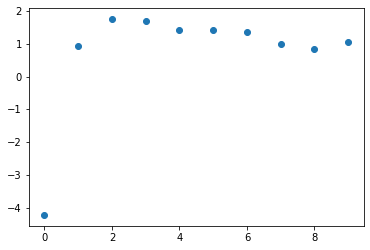

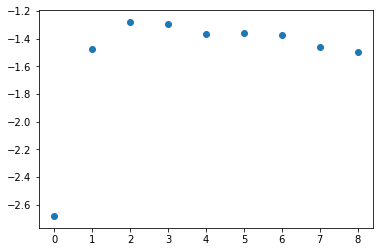

In [629]:
data = df_analisys_02.iloc[-10:,:]['MACD_12_26_9'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_macd_info_01.iloc[0,:][['ss80_macd_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

In [630]:
# Create variable names lists to naming columns

ls_ss80vars = ['ss80_macd_' + str(x) for x in range(80,8,-1) ]
ls_ss80vars

ls_ss80vars2 = ['ss80_macd_' + str(x) for x in range(8,0,-1) ]
ls_ss80vars2

ls_slopevars = ['slope_macd_' + str(x) for x in range(0,4) ]
ls_slopevars


['slope_macd_0', 'slope_macd_1', 'slope_macd_2', 'slope_macd_3']

In [631]:
#Assigns correct format to variable to apply transformations

df_macd_info_01[ls_ss80vars] = df_macd_info_01[ls_ss80vars].astype(float)
df_macd_info_01[ls_ss80vars2] = df_macd_info_01[ls_ss80vars2].astype(float)
df_macd_info_01[ls_slopevars] = df_macd_info_01[ls_slopevars].astype(float)

In [632]:
df_macd_info_01 = df_macd_info_01[df_macd_info_01.notna().all(axis=1)]

df_macd_info_01[ls_slopevars + ls_ss80vars + ls_ss80vars2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503 entries, 0 to 502
Data columns (total 84 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   slope_macd_0  503 non-null    float64
 1   slope_macd_1  503 non-null    float64
 2   slope_macd_2  503 non-null    float64
 3   slope_macd_3  503 non-null    float64
 4   ss80_macd_80  503 non-null    float64
 5   ss80_macd_79  503 non-null    float64
 6   ss80_macd_78  503 non-null    float64
 7   ss80_macd_77  503 non-null    float64
 8   ss80_macd_76  503 non-null    float64
 9   ss80_macd_75  503 non-null    float64
 10  ss80_macd_74  503 non-null    float64
 11  ss80_macd_73  503 non-null    float64
 12  ss80_macd_72  503 non-null    float64
 13  ss80_macd_71  503 non-null    float64
 14  ss80_macd_70  503 non-null    float64
 15  ss80_macd_69  503 non-null    float64
 16  ss80_macd_68  503 non-null    float64
 17  ss80_macd_67  503 non-null    float64
 18  ss80_macd_66  503 non-null    

In [633]:
#Defines X vector to all process

X = df_macd_info_01[ls_ss80vars + ls_ss80vars2 + ls_slopevars]
print(X.shape)


(503, 84)


In [634]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss80vars2),
                                     ("pca1", pca_pip, ls_ss80vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [635]:
Xtr.shape

(503, 15)

In [636]:
#Defines the df of all transformations

ls_ss80pcavars = ['ss80_macd_c1','ss80_macd_c2','ss80_macd_c3']

df_macd_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss80vars2 + ls_ss80pcavars )
print(df_macd_info_tr_01.shape)
df_macd_info_tr_01

(503, 15)


,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3
0,-0.700447,-0.281362,-0.104126,-0.047178,-1.459180,-1.373517,-1.357832,-1.362377,-1.295856,-1.280060,-1.472322,-2.680954,-2.851233,-5.855911,1.240951
1,-0.088978,-0.014790,0.015360,-0.008546,-1.510437,-1.474794,-1.388408,-1.372590,-1.377173,-1.310091,-1.294162,-1.488046,-2.043988,-6.277025,1.625889
2,0.040545,0.024518,0.028813,-0.013774,-1.415188,-1.463567,-1.428749,-1.344363,-1.328911,-1.333389,-1.267860,-1.252299,-1.189309,-6.476396,1.905046
3,0.030072,0.032781,0.018358,-0.029705,-1.333809,-1.384936,-1.432597,-1.398296,-1.315164,-1.299942,-1.304353,-1.239797,-0.436396,-6.630036,2.081395
4,0.005357,0.035166,-0.003138,-0.044597,-1.190441,-1.315757,-1.366425,-1.413658,-1.379666,-1.297279,-1.282194,-1.286565,0.250040,-6.756403,2.171607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.033825,-0.009536,0.000364,-0.020377,-1.160297,-1.197950,-1.150702,-1.076446,-1.194270,-1.195536,-1.186750,-1.127887,-5.603237,-2.748724,1.659511
499,0.003768,-0.019159,-0.006723,-0.027583,-1.123661,-1.164808,-1.202542,-1.155193,-1.080779,-1.198854,-1.200123,-1.191318,-5.151535,-3.231178,2.069526
500,-0.059708,-0.003885,-0.011927,-0.031720,-1.069178,-1.124851,-1.166024,-1.203780,-1.156402,-1.081944,-1.200090,-1.201359,-4.653553,-3.722487,2.461936
501,-0.021869,0.005377,-0.022817,-0.035126,-0.956758,-1.071435,-1.127173,-1.168394,-1.206194,-1.158761,-1.084215,-1.202500,-4.159984,-4.202991,2.789755


In [637]:
# Concat the Datetime to the transformed data

df_macd_info_tr_01 = pd.concat([df_macd_info_01['Datetime'],df_macd_info_tr_01],axis=1)
df_macd_info_tr_01

,Datetime,slope_macd_0,slope_macd_1,slope_macd_2,slope_macd_3,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1,ss80_macd_c1,ss80_macd_c2,ss80_macd_c3
0,2022-03-04 16:00:00,-0.700447,-0.281362,-0.104126,-0.047178,-1.459180,-1.373517,-1.357832,-1.362377,-1.295856,-1.280060,-1.472322,-2.680954,-2.851233,-5.855911,1.240951
1,2022-03-02 15:55:00,-0.088978,-0.014790,0.015360,-0.008546,-1.510437,-1.474794,-1.388408,-1.372590,-1.377173,-1.310091,-1.294162,-1.488046,-2.043988,-6.277025,1.625889
2,2022-03-02 15:50:00,0.040545,0.024518,0.028813,-0.013774,-1.415188,-1.463567,-1.428749,-1.344363,-1.328911,-1.333389,-1.267860,-1.252299,-1.189309,-6.476396,1.905046
3,2022-03-02 15:45:00,0.030072,0.032781,0.018358,-0.029705,-1.333809,-1.384936,-1.432597,-1.398296,-1.315164,-1.299942,-1.304353,-1.239797,-0.436396,-6.630036,2.081395
4,2022-03-02 15:40:00,0.005357,0.035166,-0.003138,-0.044597,-1.190441,-1.315757,-1.366425,-1.413658,-1.379666,-1.297279,-1.282194,-1.286565,0.250040,-6.756403,2.171607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2022-02-22 13:30:00,0.033825,-0.009536,0.000364,-0.020377,-1.160297,-1.197950,-1.150702,-1.076446,-1.194270,-1.195536,-1.186750,-1.127887,-5.603237,-2.748724,1.659511
499,2022-02-22 13:25:00,0.003768,-0.019159,-0.006723,-0.027583,-1.123661,-1.164808,-1.202542,-1.155193,-1.080779,-1.198854,-1.200123,-1.191318,-5.151535,-3.231178,2.069526
500,2022-02-22 13:20:00,-0.059708,-0.003885,-0.011927,-0.031720,-1.069178,-1.124851,-1.166024,-1.203780,-1.156402,-1.081944,-1.200090,-1.201359,-4.653553,-3.722487,2.461936
501,2022-02-22 13:15:00,-0.021869,0.005377,-0.022817,-0.035126,-0.956758,-1.071435,-1.127173,-1.168394,-1.206194,-1.158761,-1.084215,-1.202500,-4.159984,-4.202991,2.789755


In [638]:
pd.concat([df_macd_info_tr_01[['Datetime'] +ls_ss80vars2].iloc[0:1,:],
           df_macd_info_01[['Datetime'] +ls_ss80vars2].iloc[0:1,:]],axis=0)

,Datetime,ss80_macd_8,ss80_macd_7,ss80_macd_6,ss80_macd_5,ss80_macd_4,ss80_macd_3,ss80_macd_2,ss80_macd_1
0,2022-03-04 16:00:00,-1.45918,-1.373517,-1.357832,-1.362377,-1.295856,-1.28006,-1.472322,-2.680954
0,2022-03-04 16:00:00,-1.45918,-1.373517,-1.357832,-1.362377,-1.295856,-1.28006,-1.472322,-2.680954


# VOLUME DATA

In [639]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys_02)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 50

    if i==0:
        X = df_analisys_02.iloc[-(nro_close_lag + i):,][['Volume']]
        Datetime = df_analisys_02.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys_02.iloc[-(nro_close_lag + i):-i,][['Volume']]
        Datetime = df_analisys_02.iloc[-(i+1):,]['Datetime'].iloc[0]
        
    if X.loc[max(X.index)][0] == 0:
        X.loc[max(X.index)][0] = X.loc[max(X.index)-1][0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss = sscaler.fit_transform(X)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss20_vols_' + str(x) for x in range(len(X_ss),0,-1) ]
    df_ssdata = pd.DataFrame(X_ss.T,columns=ls_columns)
    ###############################################################################################


    ###############################################################################################
    nro_close_lag2 = 100

    if i==0:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):,][['Volume']]
    else:
        X2 = df_analisys_02.iloc[-(nro_close_lag2 + i):-i,][['Volume']]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X2_ss = sscaler.fit_transform(X2)
    #print(X2)

    # Obtains the df of variables of close lags
    ls_columns = ['ss80_vols_' + str(x) for x in range(len(X2_ss),0,-1) ]
    df_ssdata2 = pd.DataFrame(X2_ss.T,columns=ls_columns)

    ###############################################################################################


    ###############################################################################################
    #Computes slopes before the last close
    ls_linreg_coefs = []
    
    for j in [3,5,8,13]:
        y = X_ss[-j:]
        x = np.array([range(0,j)]).reshape(-1,1)


        linreg = LinearRegression()
        
        try:
            linreg.fit(x,y)
            linreg_coef = linreg.coef_[0][0]

            ls_linreg_coefs.append(linreg_coef)
            
        except:
            pass

    ls_columns = ['slope_vols_' + str(x) for x in range(0,len(ls_linreg_coefs)) ]

    df_linregcoefs = pd.DataFrame(np.array([ls_linreg_coefs]),columns=ls_columns)
    df_linregcoefs
    ###############################################################################################

    # Joins the ss closes df with the slopes df
    df_vols_info = pd.concat([df_ssdata,df_ssdata2,df_linregcoefs],axis=1,sort=False)
    df_vols_info['Datetime'] = Datetime
    
    if i == 0:
        df_vols_info_01 = df_vols_info.copy()
    else:
        df_vols_info_01 = df_vols_info_01.append(df_vols_info,sort=False).copy()
        
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
df_vols_info_01

,ss20_vols_50,ss20_vols_49,ss20_vols_48,ss20_vols_47,ss20_vols_46,ss20_vols_45,ss20_vols_44,ss20_vols_43,ss20_vols_42,ss20_vols_41,...,ss80_vols_5,ss80_vols_4,ss80_vols_3,ss80_vols_2,ss80_vols_1,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,Datetime
0,-0.251363,-0.289401,-0.264315,-0.039393,-0.224937,-0.347684,-0.279327,-0.296073,-0.296335,-0.304184,...,0.352201,0.907312,2.134421,5.470396,-1.341298,1.367502,1.213337,0.716379,0.355412,2022-03-04 16:00:00
1,-0.229534,-0.203907,-0.254082,-0.220992,0.075701,-0.169048,-0.330962,-0.240794,-0.262883,-0.263228,...,0.139541,0.345840,0.905529,2.142758,5.506242,2.467397,1.344021,0.700711,0.331372,2022-03-02 15:55:00
2,-0.016092,-0.217757,-0.163992,-0.269259,-0.199835,0.422630,-0.090856,-0.430555,-0.241381,-0.287724,...,0.135108,0.239271,0.486610,1.157643,2.641004,2.021857,1.113069,0.654167,0.328858,2022-03-02 15:50:00
3,0.685600,0.149331,-0.185724,-0.096396,-0.271293,-0.155948,0.878242,0.025114,-0.539277,-0.224974,...,-0.182625,0.170966,0.278948,0.535356,1.230990,1.431956,0.960096,0.599130,0.312414,2022-03-02 15:45:00
4,1.080819,1.056030,0.319397,-0.140845,-0.018141,-0.258384,-0.099943,1.320648,0.148769,-0.626494,...,-0.179294,-0.166662,0.189283,0.297984,0.556098,0.752850,0.794453,0.502210,0.303974,2022-03-02 15:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.093679,-0.769558,0.644146,1.622865,-0.403774,-0.523960,0.377223,NaN,NaN,2022-02-18 13:25:00
578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.090967,-0.794969,0.496070,1.389867,1.092418,NaN,NaN,NaN,2022-02-18 13:20:00
579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.910935,-0.481361,1.392296,1.151616,NaN,NaN,NaN,2022-02-18 13:15:00
580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.000000,1.000000,NaN,NaN,NaN,NaN,2022-02-18 13:10:00


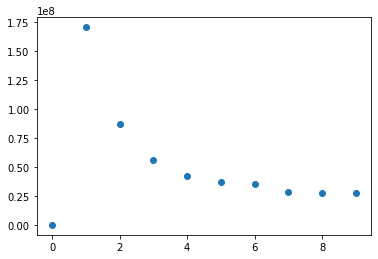

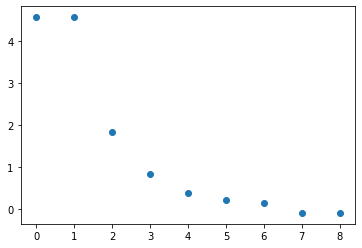

ss20_vols_1     4.56831
ss20_vols_2     4.56831
ss20_vols_3    1.833307
ss20_vols_4    0.827259
ss20_vols_5    0.372151
ss20_vols_6      0.2044
ss20_vols_7    0.133754
ss20_vols_8   -0.097578
ss20_vols_9   -0.105787
Name: 0, dtype: object

In [640]:
data = df_analisys_02.iloc[-10:,:]['Volume'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_vols_info_01.iloc[0,:][['ss20_vols_' + str(x) for x in range(1,10) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

data

In [641]:
# Create variable names lists to naming columns

ls_ss80vars = ['ss80_vols_' + str(x) for x in range(100,0,-1)]
ls_ss80vars

ls_ss20vars = ['ss20_vols_' + str(x) for x in range(50,8,-1) ]
ls_ss20vars

ls_ss20vars2 = ['ss20_vols_' + str(x) for x in range(8,0,-1) ]
ls_ss20vars2

ls_slopevars = ['slope_vols_' + str(x) for x in range(0,4) ]
ls_slopevars

['slope_vols_0', 'slope_vols_1', 'slope_vols_2', 'slope_vols_3']

In [642]:
#Assigns correct format to variable to apply transformations

df_vols_info_01[ls_ss20vars2] = df_vols_info_01[ls_ss20vars2].astype(float)
df_vols_info_01[ls_ss20vars] = df_vols_info_01[ls_ss20vars].astype(float)
df_vols_info_01[ls_ss80vars] = df_vols_info_01[ls_ss80vars].astype(float)
df_vols_info_01[ls_slopevars] = df_vols_info_01[ls_slopevars].astype(float)

In [643]:
df_vols_info_01 = df_vols_info_01[df_vols_info_01.notna().all(axis=1)]
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
print(df_vols_info_01.shape)

df_vols_info_01[ls_slopevars + ls_ss20vars2 + ls_ss20vars + ls_ss80vars].info()



(483, 155)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Columns: 154 entries, slope_vols_0 to ss80_vols_1
dtypes: float64(154)
memory usage: 581.2 KB


In [644]:
#Defines X vector to all process

X = df_vols_info_01[ls_ss20vars + ls_ss80vars + ls_slopevars + ls_ss20vars2]
print(X.shape)


(483, 154)


In [645]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_slopevars + ls_ss20vars2),
                                     ("pca1", pca_pip, ls_ss20vars),
                                     ("pca2", pca_pip, ls_ss80vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [646]:
Xtr.shape

(483, 18)

In [647]:
#Defines the df of all transformations

ls_ss20pcavars = ['ss20_vols_c1','ss20_vols_c2','ss20_vols_c3']
ls_ss80pcavars = ['ss80_vols_c1','ss80_vols_c2','ss80_vols_c3']

df_vols_info_tr_01 = pd.DataFrame(Xtr,columns=ls_slopevars + ls_ss20vars2 + ls_ss20pcavars + ls_ss80pcavars)
print(df_vols_info_tr_01.shape)
df_vols_info_tr_01

(483, 18)


,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,ss20_vols_8,ss20_vols_7,ss20_vols_6,ss20_vols_5,ss20_vols_4,ss20_vols_3,ss20_vols_2,ss20_vols_1,ss20_vols_c1,ss20_vols_c2,ss20_vols_c3,ss80_vols_c1,ss80_vols_c2,ss80_vols_c3
0,1.367502,1.213337,0.716379,0.355412,-0.097578,0.133754,0.204400,0.372151,0.827259,1.833307,4.568310,4.568310,-1.291327,0.524453,-0.272255,-1.896287,-4.547502,2.786382
1,2.467397,1.344021,0.700711,0.331372,-0.011879,-0.001050,0.304098,0.397287,0.618566,1.218897,2.545967,6.153690,-1.208541,0.530392,-0.280168,-2.384167,-4.694227,2.865088
2,2.021857,1.113069,0.654167,0.328858,0.184759,0.238886,0.261605,0.901811,1.097322,1.561568,2.821071,5.605283,-0.994668,0.990294,-0.351428,-3.160211,-4.588275,2.165839
3,1.431956,0.960096,0.599130,0.312414,0.070680,0.483033,0.572963,0.610709,1.674375,1.999204,2.770524,4.863117,-0.423850,1.596760,-0.331208,-3.570342,-4.166365,1.348326
4,0.752850,0.794453,0.502210,0.303974,0.494363,0.211360,0.777779,0.901308,0.953158,2.414237,2.860432,3.919936,0.461394,2.026792,-0.176159,-3.904351,-3.771218,0.661361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,-0.208350,-0.265779,0.144506,0.033236,-0.016787,0.300709,1.007068,1.931928,1.866210,1.377096,1.151479,0.960396,-1.322748,3.991774,-1.364456,-4.362972,-2.703357,-1.979789
479,-0.360247,-0.026815,0.106529,0.074971,1.707613,-0.004906,0.315150,1.027205,1.959522,1.893275,1.400216,1.172781,-0.751251,3.659572,-1.381250,-4.546303,-2.323414,-2.190727
480,-0.281774,0.305923,-0.050538,0.118585,3.109351,1.728223,0.002716,0.325199,1.042654,1.982042,1.915292,1.418494,0.091714,3.016051,-1.063294,-4.691918,-1.919157,-2.316991
481,0.445046,0.559164,-0.068560,0.136672,1.724939,3.194187,1.785435,0.025416,0.354349,1.086154,2.044331,1.976246,0.616707,2.489895,-1.050092,-4.817013,-1.498469,-2.364264


In [648]:
# Concat the Datetime to the transformed data

df_vols_info_tr_01 = pd.concat([df_vols_info_01['Datetime'],df_vols_info_tr_01],axis=1)
df_vols_info_tr_01

,Datetime,slope_vols_0,slope_vols_1,slope_vols_2,slope_vols_3,ss20_vols_8,ss20_vols_7,ss20_vols_6,ss20_vols_5,ss20_vols_4,ss20_vols_3,ss20_vols_2,ss20_vols_1,ss20_vols_c1,ss20_vols_c2,ss20_vols_c3,ss80_vols_c1,ss80_vols_c2,ss80_vols_c3
0,2022-03-04 16:00:00,1.367502,1.213337,0.716379,0.355412,-0.097578,0.133754,0.204400,0.372151,0.827259,1.833307,4.568310,4.568310,-1.291327,0.524453,-0.272255,-1.896287,-4.547502,2.786382
1,2022-03-02 15:55:00,2.467397,1.344021,0.700711,0.331372,-0.011879,-0.001050,0.304098,0.397287,0.618566,1.218897,2.545967,6.153690,-1.208541,0.530392,-0.280168,-2.384167,-4.694227,2.865088
2,2022-03-02 15:50:00,2.021857,1.113069,0.654167,0.328858,0.184759,0.238886,0.261605,0.901811,1.097322,1.561568,2.821071,5.605283,-0.994668,0.990294,-0.351428,-3.160211,-4.588275,2.165839
3,2022-03-02 15:45:00,1.431956,0.960096,0.599130,0.312414,0.070680,0.483033,0.572963,0.610709,1.674375,1.999204,2.770524,4.863117,-0.423850,1.596760,-0.331208,-3.570342,-4.166365,1.348326
4,2022-03-02 15:40:00,0.752850,0.794453,0.502210,0.303974,0.494363,0.211360,0.777779,0.901308,0.953158,2.414237,2.860432,3.919936,0.461394,2.026792,-0.176159,-3.904351,-3.771218,0.661361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,2022-02-22 15:10:00,-0.208350,-0.265779,0.144506,0.033236,-0.016787,0.300709,1.007068,1.931928,1.866210,1.377096,1.151479,0.960396,-1.322748,3.991774,-1.364456,-4.362972,-2.703357,-1.979789
479,2022-02-22 15:05:00,-0.360247,-0.026815,0.106529,0.074971,1.707613,-0.004906,0.315150,1.027205,1.959522,1.893275,1.400216,1.172781,-0.751251,3.659572,-1.381250,-4.546303,-2.323414,-2.190727
480,2022-02-22 15:00:00,-0.281774,0.305923,-0.050538,0.118585,3.109351,1.728223,0.002716,0.325199,1.042654,1.982042,1.915292,1.418494,0.091714,3.016051,-1.063294,-4.691918,-1.919157,-2.316991
481,2022-02-22 14:55:00,0.445046,0.559164,-0.068560,0.136672,1.724939,3.194187,1.785435,0.025416,0.354349,1.086154,2.044331,1.976246,0.616707,2.489895,-1.050092,-4.817013,-1.498469,-2.364264


In [649]:
pd.concat([df_vols_info_tr_01[['Datetime'] +ls_ss20vars2].iloc[0:1,:],
           df_vols_info_01[['Datetime'] +ls_ss20vars2].iloc[0:1,:]],axis=0)

,Datetime,ss20_vols_8,ss20_vols_7,ss20_vols_6,ss20_vols_5,ss20_vols_4,ss20_vols_3,ss20_vols_2,ss20_vols_1
0,2022-03-04 16:00:00,-0.097578,0.133754,0.2044,0.372151,0.827259,1.833307,4.56831,4.56831
0,2022-03-04 16:00:00,-0.097578,0.133754,0.2044,0.372151,0.827259,1.833307,4.56831,4.56831


# Attaches target variable to the df with transformations

In [650]:
ls_tgcols = ['date','Datetime','Close','target_order','target_order_bin','target_close','target_difference','target_date','target_date_diff']


df_transformations_100 = pd.merge(df_close_info_tr_01,
                           df_macdh_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()

df_transformations_100 = pd.merge(df_transformations_100,
                           df_macd_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()

df_transformations_100 = pd.merge(df_transformations_100,
                           df_vols_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()

df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_02[ls_tgcols],
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['Datetime']).reset_index(drop=True)

print(df_analisys_100.shape)

df_analisys_100


(383, 77)


,Datetime,slope_close_0,slope_close_1,slope_close_2,slope_close_3,ss1_close_8,ss1_close_7,ss1_close_6,ss1_close_5,ss1_close_4,...,ss80_vols_c2,ss80_vols_c3,date,Close,target_order,target_order_bin,target_close,target_difference,target_date,target_date_diff
0,2022-02-24 10:10:00,0.299110,0.042748,0.058686,-0.140530,-1.988923,-2.244809,-1.838221,-1.813352,-1.625684,...,-4.875088,2.459691,2022-02-24,4170.500000,BUY,1,4194.270020,24.0,2022-02-24 11:10:00,60.0
1,2022-02-24 10:15:00,0.276859,0.129722,0.094889,-0.088627,-2.197406,-1.790056,-1.765140,-1.577119,-2.047950,...,-4.752197,2.084254,2022-02-24,4180.500000,BUY,1,4200.850098,20.0,2022-02-24 11:15:00,60.0
2,2022-02-24 10:20:00,0.021759,0.184302,0.071939,-0.040717,-1.737078,-1.712111,-1.523707,-1.995499,-1.728903,...,-4.605365,1.663404,2022-02-24,4172.470215,BUY,1,4194.270020,22.0,2022-02-24 11:10:00,50.0
3,2022-02-24 10:25:00,-0.196954,0.036114,0.055254,0.005070,-1.646924,-1.459216,-1.929265,-1.663654,-1.330918,...,-4.398657,1.163471,2022-02-24,4162.600098,BUY,1,4189.759766,27.0,2022-02-24 11:05:00,40.0
4,2022-02-24 10:30:00,-0.011774,-0.035421,0.053647,0.066477,-1.407629,-1.877554,-1.612013,-1.279365,-1.059362,...,-4.179055,0.666760,2022-02-24,4171.399902,BUY,1,4194.270020,23.0,2022-02-24 11:10:00,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,2022-03-02 15:40:00,-0.222853,0.120627,0.122880,0.018975,0.384605,-0.256035,0.131038,0.094234,0.651748,...,-3.771218,0.661361,2022-03-02,4394.109863,SELL2,0,4328.870117,-65.0,2022-03-04 16:00:00,2900.0
379,2022-03-02 15:45:00,0.223533,0.063572,0.180648,0.072512,-0.306118,0.082137,0.045221,0.604438,1.050103,...,-4.166365,1.348326,2022-03-02,4398.080078,SELL2,0,4328.870117,-69.0,2022-03-04 16:00:00,2895.0
380,2022-03-02 15:50:00,0.165229,0.018283,0.139491,0.108433,0.012307,-0.027171,0.570853,1.047445,0.671726,...,-4.588275,2.165839,2022-03-02,4396.370117,SELL2,0,4328.870117,-68.0,2022-03-04 16:00:00,2890.0
381,2022-03-02 15:55:00,-0.975240,-0.252336,-0.033949,0.051471,-0.070386,0.569913,1.080197,0.677917,0.568308,...,-4.694227,2.865088,2022-03-02,4385.620117,SELL2,0,4328.870117,-57.0,2022-03-04 16:00:00,2885.0


In [651]:
print(min(df_analisys_100['Datetime']))
print(max(df_analisys_100['Datetime']))

2022-02-24 10:10:00
2022-03-04 16:00:00


In [652]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           134
3   BUY2            40
4   NULL             1
2   SELL            86
1  SELL2           122


In [653]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_5m_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(383, 77)
2022-03-04 21:54:59.016694
